

# > Mounting Google Drive

In [15]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import torchvision

# The Oxford IIIT-Pet Dataset
This dataset consists of a 37 category pet dataset with roughly 200 images for each class. The images have a large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed, head ROI, and pixel level trimap segmentation. 

The annotations are available for every image in the dataset: 

1.   species and breed name
2.   a tight bounding box (ROI) around the head of the animal
3.   a pixel level foreground-background segmentation (Trimap)

For the purpose of semantic segmentation using U-Net we will be using trimaps provided in the annotations directory to get the desired masks.
If one wishes to download dataset to local pc, you can do it using this [link](https://www.robots.ox.ac.uk/~vgg/data/pets/)


In [3]:
dataset1= torchvision.datasets.OxfordIIITPet("/content/",target_types='segmentation',download=True)

  0%|          | 0/791918971 [00:00<?, ?it/s]

Extracting /content/oxford-iiit-pet/images.tar.gz to /content/oxford-iiit-pet


  0%|          | 0/19173078 [00:00<?, ?it/s]

Extracting /content/oxford-iiit-pet/annotations.tar.gz to /content/oxford-iiit-pet


In [5]:
dataset1

Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: /content/



```
Importing Libraries
```



In [6]:
from matplotlib import pyplot as plt 
%matplotlib inline 
from pathlib import Path
import os
from random import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from PIL import Image
from torch.utils.data import Dataset
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import DataLoader
from math import ceil
import pandas as pd
import cv2

In [7]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask



@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask



# Dice Score
The Dice score is often used to quantify the performance of image segmentation methods. There you annotate some ground truth region in your image and then make an automated algorithm to do it. You validate the algorithm by calculating the Dice score, which is a measure of how similar the objects are. So it is the size of the overlap of the two segmentations divided by the total size of the two objects.Using the same terms as describing accuracy, the Dice score is:

\begin{align}
Dice~Score = \frac{2 \cdot number~ of ~true~ positives}{2⋅number~ of~ true~ positives + number~ of ~false ~positives + number~ of ~false ~negatives}
\end{align}

In the case of image segmentation, let's say that you have a mask with ground truth, let's call the mask ***A*** like you suggest. So the mask has values 1 in the pixels where there is something you are trying to find and else zero. Now you have an algorithm to generate image/mask ***B***, which also has to be a binary image, i.e. you create a mask for you segmentation. Then we have the following:


\begin{align}
Dice~Score = \frac{2 \cdot \mid A ~∩ B ~\mid}{\mid A \mid + \mid B ~\mid}
\end{align}

In [8]:


def dice_score(input,target,reduce_batch=False,epsilon=1e-6):
    if input.dim ==2 or reduce_batch:
        intersecion = torch.dot(input.reshape(-1),target.reshape(-1))
        set_sum = torch.sum(input) + torch.sum(target)

        if set_sum.item() ==0:
            set_sum = 2*intersecion
        
        return (2*intersecion+epsilon)/(set_sum + epsilon)

    else:
        dice =0
        for i in range(input.shape[0]):
            dice+=dice_score(input= input[i], target= target[i],reduce_batch=True, epsilon=epsilon)
        
        return dice /input.shape[0]


def dice_coeff_multilabel(input,target,reduce_batch=False, epsilon=1e-6):
    dice =0
    for i in range(input.shape[1]):
        dice += dice_score(input=input[:,i,:,:], target= target[:,i,:,:], reduce_batch=reduce_batch, epsilon=epsilon)
    
    return dice/input.shape[1]


def dice_loss(input,target,multiclass=False):

    fn = dice_coeff_multilabel if multiclass else dice_score

    return 1 - fn(input,target,reduce_batch=True)
    


def display_output(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')

  plt.show()

In [9]:
class ImageData(Dataset):
    """Dataset class for out Oxford IIIT-Pet Dataset
      We will read in all the filenames in the image directory and masks directory
      but we won't store it anywhere until it is needed, the task of which is left upto
      __getitem__ method of this class. This is memory efficient because all the images
      are not stored in the memory at once but read as required.
    """
    def __init__(self, dir_images, dir_masks) -> None:
        super(ImageData, self).__init__()
        
        self.dir_images =dir_images
        self.dir_masks = dir_masks
        self.file_names =[os.path.splitext(file)[0] for file in os.listdir(self.dir_masks) if not file.startswith('.')]
        self.file_names =self.file_names[0:1000]


    def __len__(self):
      """ returns the length of our dataset"""
      return len(self.file_names)

    def __getitem__(self, index):
      """ reads the file and returns a dictionary which 
          stores image and its corresponding mask
      """

      filename = self.file_names[index]
      # print(filename)

      try:
        image = Image.open(self.dir_images+filename+".jpg")
        mask = Image.open(self.dir_masks+filename+".png")
      except Exception as e:
        print(e)

      image = pre_process(image,False)
      mask = pre_process(mask, True)

      return {
          'image': torch.as_tensor(image.copy()).float().contiguous(),
          'mask': torch.as_tensor(mask.copy()).float().contiguous()
      }

        

def pre_process(pil_img, is_mask):
    """Function to preprocess the image
      pil_img : Image in PIL format
      is_mask : checks if the image is mask or not
    """

    img_np = np.array(pil_img.copy())
    # img_np.setflags(write=1)

    if not is_mask:
        if img_np.ndim ==2:
            img_np = np.stack((img_np,)*3,axis=0)
        else:
            # permuting the axes of the array to make it of the form ( channels, width, height)
            img_np = img_np.transpose((2,0,1))
        
        # normalization
        img_np =img_np/255
    else:
      # normalization for masks
      # because all the pixels represent a category from
      # [1,n_classes] we need classes in the range [0,n_classes)
      # for computation in PyTorch
      img_np-=1

    return img_np

def shuffle_dataset(x,y):
    rnd = range(0, x.shape[0])
    rnd = random.shuffle(rnd)

    x_out = np.zeros_like(x)
    y_out = np.zeros_like(y)

    for i in range(len(rnd)):
        x_out[rnd[i],:,:,:] = x[i,:,:,:]
        y_out[rnd[i],:,:] = y[i,:,:]

    return x_out, y_out

def split_dataset(x,y,per_train):
    n_train = int(x.shape[0])*per_train
    n_val = int(x.shape[0]) - n_train

    train_x = x[:n_train,:,:,:]
    train_y = y[:n_train,:,:]

    test_x = x[n_train:,:,:,:]
    test_y = y[n_train:,:,:]

    return train_x,train_y,test_x,test_y    
        

# U-Net Model

In [10]:


class DoubleConvNet(nn.Module):

    def __init__(self, in_channels, out_channels, mid_channels=None) -> None:
        """
          in_channels : number of input channels
          out_channels: number of output channels or classes
        """
        super(DoubleConvNet,self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        if not mid_channels:
            mid_channels=out_channels

        self.doubleConvNet = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self,input):
        return self.doubleConvNet(input)

class down(nn.Module):
    """encoder unit which represents the DOWN block of the U-Net"""
    def __init__(self, in_channels, out_channels) -> None:
        super(down,self).__init__()
      
        self.max_pool_conv= nn.Sequential(
            nn.MaxPool2d(2,stride=2),
            DoubleConvNet(in_channels,out_channels)
        )

    def forward(self, input):
        return self.max_pool_conv(input)

class up(nn.Module):
    """decoder unit which represents the UP block of the U-Net"""
    def __init__(self,in_channels,out_channels, bilinear =True) -> None:
        super(up,self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2,mode ='bilinear',align_corners=True)
            self.conv = DoubleConvNet(in_channels, out_channels, in_channels//2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
            self.conv = DoubleConvNet(in_channels, out_channels)

    
    def forward(self, x1,x2):
        x1 =self.up(x1)

        # input shape is (n_channels, height, width)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX//2, diffX- diffY//2,diffY//2, diffY -diffY//2])

        x= torch.cat([x2,x1], dim=1)

        return self.conv(x)



class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear= False, pretrained= False):
        super(UNet,self).__init__()

        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear


        self.inp = DoubleConvNet(n_channels, 64)
        self.down1 = down(64,128)
        self.down2 = down(128,256)
        self.down3 = down(256,512)

        factor = 2 if bilinear else 1
        self.down4 = down(512,1024//factor)
        
        self.up1 = up(1024,512//factor,bilinear=bilinear)
        self.up2 = up(512, 256//factor, bilinear=bilinear)
        self.up3 = up(256, 128//factor,bilinear=bilinear)
        self.up4 = up(128,64,bilinear=bilinear)
        self.outp = nn.Conv2d(64, n_classes,kernel_size=1)

        # if pretrained:
        #     state_dict_path = os.path.join(os.path.dirname(__file__)+"")
        #     self.load_state_dict(torch.load(state_dict_path))

    def forward(self,input):
        d1 = self.inp(input)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)

        u1 = self.up1(d5,d4)
        u2 = self.up2(u1,d3)
        u3 = self.up3(u2,d2)
        u4 = self.up4(u3,d1)

        return self.outp(u4)


In [11]:
# list of all the usefull directories 

dir_image ="/content/drive/MyDrive/images/" 
dir_masks ="/content/drive/MyDrive/masks/"
dir_checkpoint ="/content/drive/MyDrive/checkpoint"
dir_checkpoint_images ="/content/drive/MyDrive/checkpoint_images"
dir_losses = "/content/drive/MyDrive/losses"

# Processing Dataset
Following is the code for processing of an image. Torchvision downloads the Oxford Dataset in the root folder of colab in the directory by name "oxford-iit-pet". The images in the dataset are still vary in shapes and some images have only one input channel. While the masks for the segmentation are in annotations folder inside Trimap and all of them of different shapes. Therefore, it requires preprocessing before using the data. After this process, the images and masks will be of shape (128,128,3) and (128,128) respectively. (Here each pixel inside the mask image represents one of the three categories foreground, background or object)

In [12]:
# getting the list of all the images in the dataset
image_list=[]
for file in os.listdir("/content/oxford-iiit-pet/images/"):
    if file.endswith(".jpg"):
        image_list.append(file)
    
# creating a pandas dataframe 
pet_df = pd.DataFrame(np.nan, index = np.arange(len(image_list)), columns = ['pet_images'])
pet_df['pet_images']= image_list
pet_df['image_name'] = pet_df.pet_images.str.split(pat = '.', expand = True)[0]
pet_df.info()

# creating masks directory inside the drive to store results
try:
    os.mkdir(dir_masks)
except Exception as e:
    print("Directory \"masks\" already exists")

# for preparing the masks of the output images

count = 0
for i in range(len(image_list)):
    IM_name = pet_df['image_name'].iloc[i]
    # masks in trimap folder have extension .png
    imgs=Image.open('/content/oxford-iiit-pet/annotations/trimaps/' + IM_name+'.png')
    imgs = imgs.resize((128,128), resample=Image.NEAREST)
    imgs = np.array(imgs)

    cv2.imwrite(dir_masks+ IM_name +'.png',imgs) # write png image

    
    count = count+1
    if count%1001== 0:
        print(i, imgs.shape)
        
    del imgs

try:
    os.mkdir(dir_image)
except Exception as e:
    print("Directory \"images\" already exists")

count =0
# for preparing the input data
for i in range(len(image_list)):
    IM_name = pet_df['image_name'].iloc[i]
    imgs = Image.open("/content/oxford-iiit-pet/images/"+IM_name+'.jpg')
    try:
        imgs = imgs.resize((128,128), resample= Image.BICUBIC)
        imgs = np.array(imgs)
        cv2.imwrite(dir_image+IM_name+'.jpg', imgs)
        count +=1
    except Exception as e:
        print(IM_name)
    

    if count%1001== 0:
        print(i, imgs.shape)

    del imgs

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7390 entries, 0 to 7389
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   pet_images  7390 non-null   object
 1   image_name  7390 non-null   object
dtypes: object(2)
memory usage: 173.2+ KB
1000 (128, 128)
2001 (128, 128)
3002 (128, 128)
4003 (128, 128)
5004 (128, 128)
6005 (128, 128)
7006 (128, 128)
1000 (128, 128, 3)
2001 (128, 128, 3)
3002 (128, 128, 3)
4003 (128, 128, 3)
5004 (128, 128, 3)
6005 (128, 128, 3)
7006 (128, 128, 3)


# Training Model
The model is being trained on the cloud gpu provided by Google colab.

	Device is cuda:0
model created
200


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


1000
800
dataset created


Epoch 73/100: 100%|██████████| 800/800 [01:45<00:00,  7.60img/s, loss (batch)=1.24]


(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


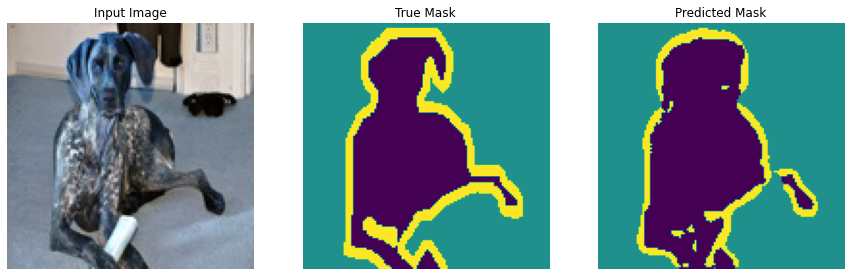

model saved


Epoch 74/100: 100%|██████████| 800/800 [01:37<00:00,  8.21img/s, loss (batch)=0.291]


(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


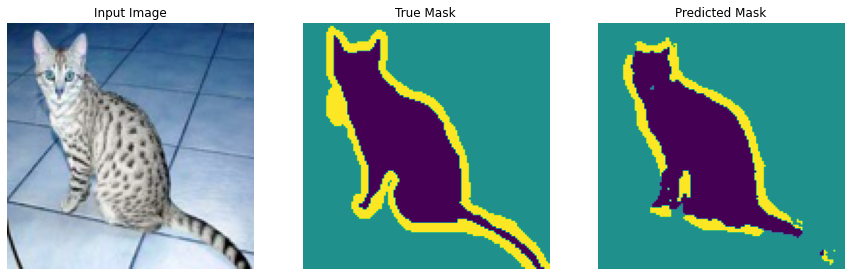

model saved


Epoch 75/100: 100%|██████████| 800/800 [01:37<00:00,  8.24img/s, loss (batch)=0.228]


(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


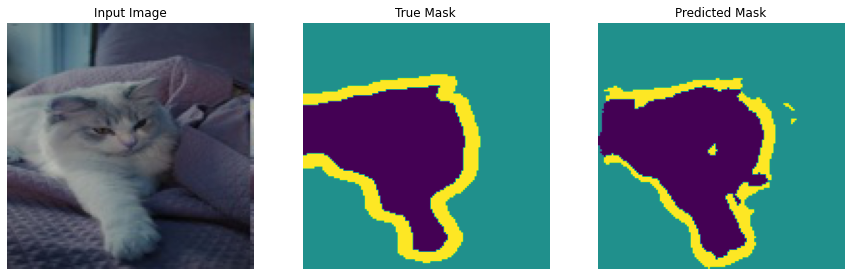

model saved


Epoch 76/100: 100%|██████████| 800/800 [01:37<00:00,  8.18img/s, loss (batch)=0.152]


(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


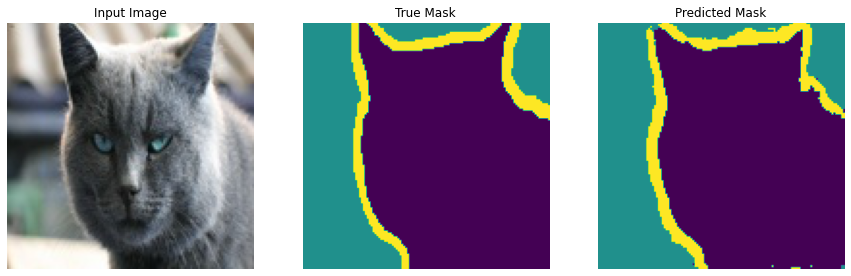

model saved


Epoch 77/100: 100%|██████████| 800/800 [01:37<00:00,  8.22img/s, loss (batch)=0.17]


(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


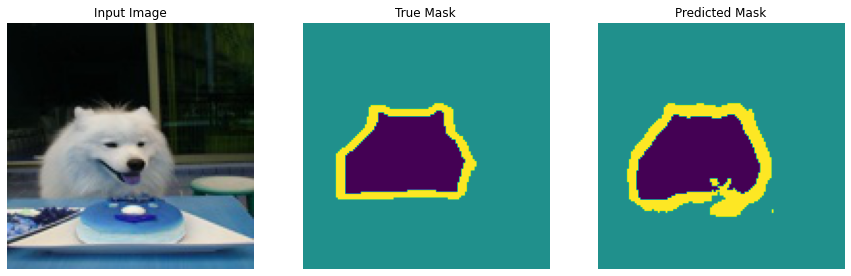

model saved


Epoch 78/100: 100%|██████████| 800/800 [01:37<00:00,  8.24img/s, loss (batch)=0.14]


(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


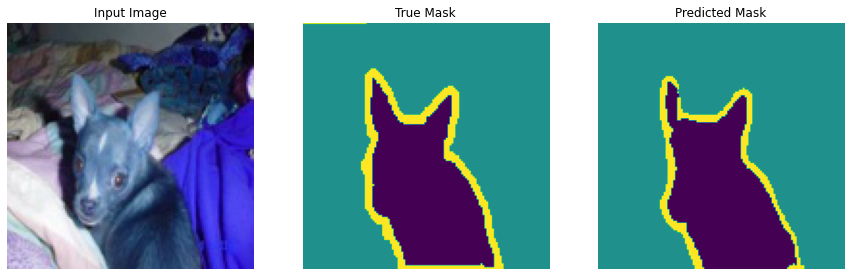

model saved


Epoch 79/100: 100%|██████████| 800/800 [01:37<00:00,  8.24img/s, loss (batch)=0.237]


(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


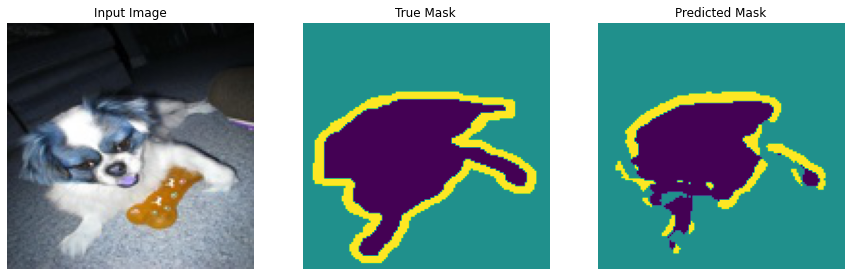

model saved


Epoch 80/100: 100%|██████████| 800/800 [01:38<00:00,  8.13img/s, loss (batch)=0.139]


(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


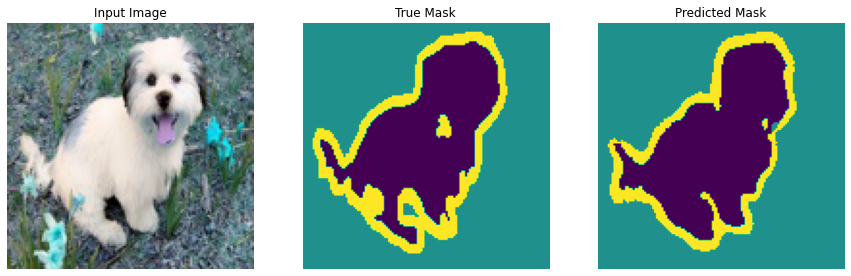

model saved


Epoch 81/100: 100%|██████████| 800/800 [01:37<00:00,  8.22img/s, loss (batch)=0.0911]


(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


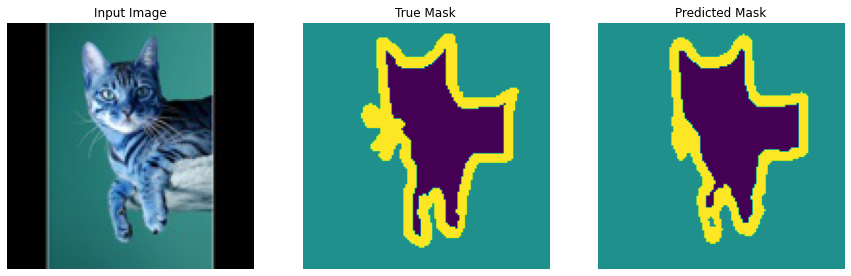

model saved


Epoch 82/100: 100%|██████████| 800/800 [01:37<00:00,  8.23img/s, loss (batch)=0.157]


(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


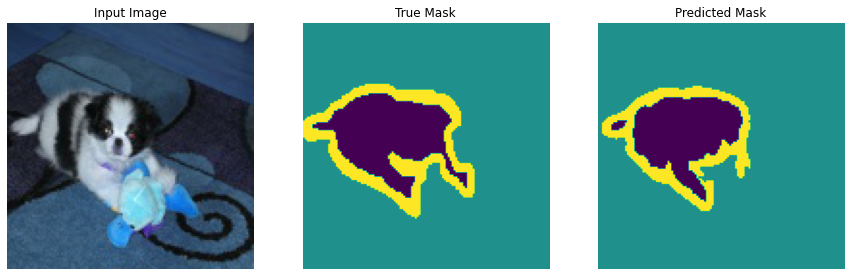

model saved


Epoch 83/100: 100%|██████████| 800/800 [01:36<00:00,  8.26img/s, loss (batch)=0.116]


(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


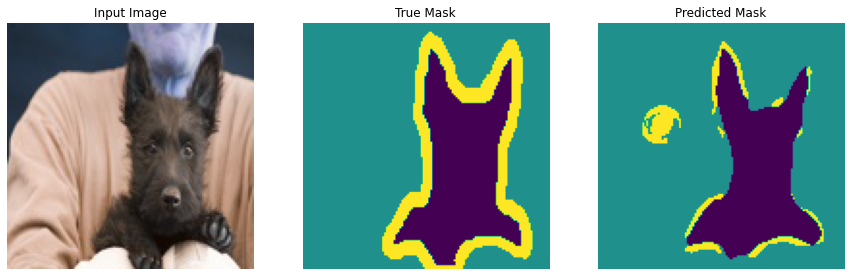

model saved


Epoch 84/100: 100%|██████████| 800/800 [01:38<00:00,  8.09img/s, loss (batch)=0.249]


(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


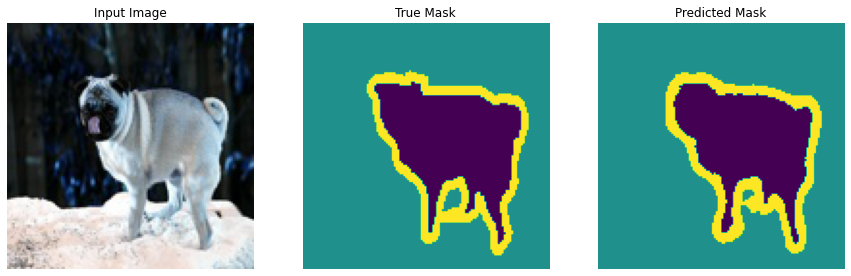

model saved


Epoch 85/100: 100%|██████████| 800/800 [01:38<00:00,  8.13img/s, loss (batch)=0.0619]


(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


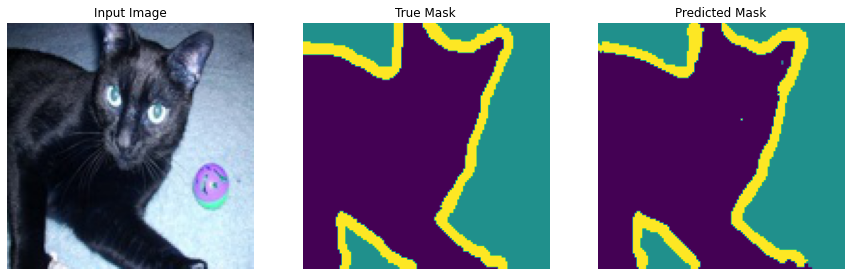

model saved


Epoch 86/100: 100%|██████████| 800/800 [01:37<00:00,  8.19img/s, loss (batch)=0.0936]


(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


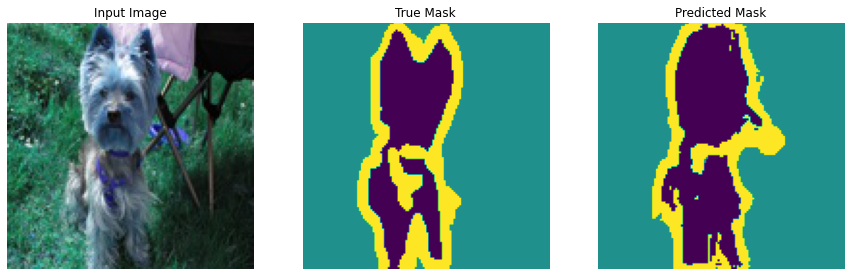

model saved


Epoch 87/100: 100%|██████████| 800/800 [01:37<00:00,  8.18img/s, loss (batch)=0.0884]


(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


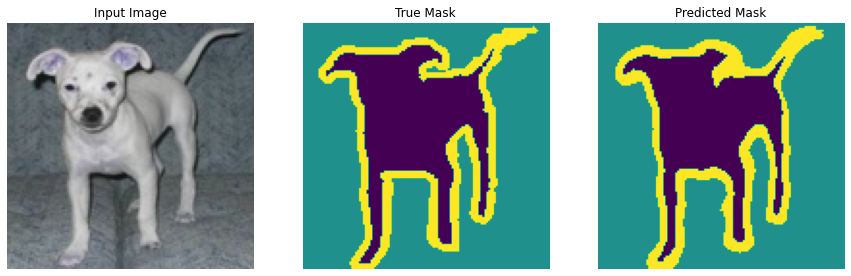

model saved


Epoch 88/100: 100%|██████████| 800/800 [01:38<00:00,  8.14img/s, loss (batch)=0.124]


(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


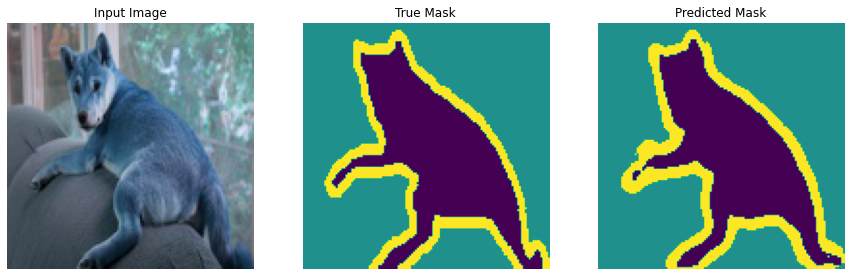

model saved


Epoch 89/100: 100%|██████████| 800/800 [01:38<00:00,  8.16img/s, loss (batch)=0.1]


(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


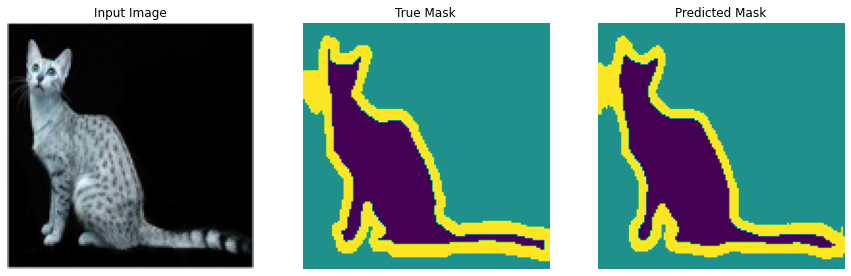

model saved


Epoch 90/100: 100%|██████████| 800/800 [01:37<00:00,  8.19img/s, loss (batch)=0.0681]


(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


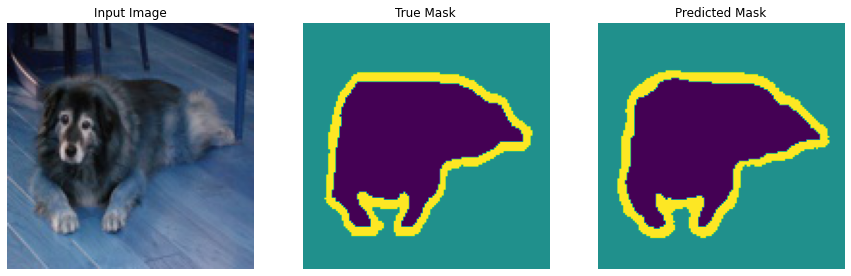

model saved


Epoch 91/100: 100%|██████████| 800/800 [01:37<00:00,  8.19img/s, loss (batch)=0.163]


(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


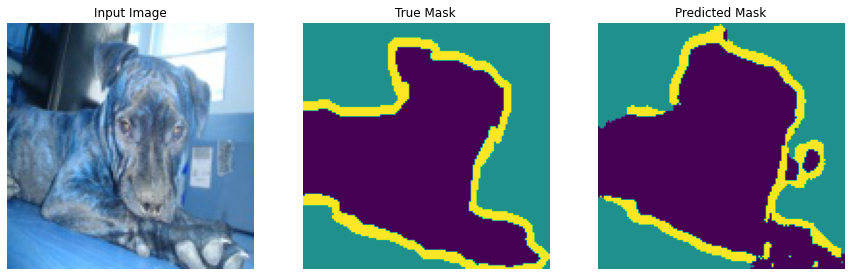

model saved


Epoch 92/100: 100%|██████████| 800/800 [01:39<00:00,  8.05img/s, loss (batch)=0.237]


(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


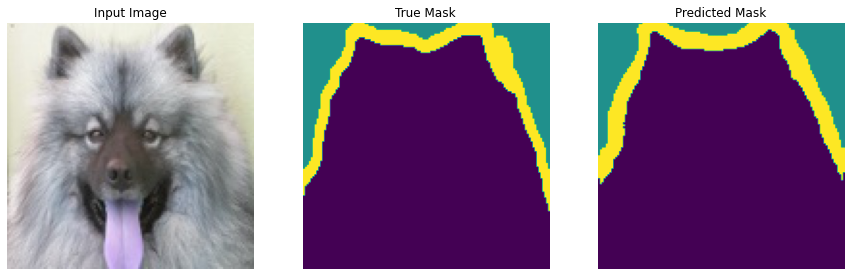

model saved


Epoch 93/100: 100%|██████████| 800/800 [01:38<00:00,  8.16img/s, loss (batch)=0.122]


(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


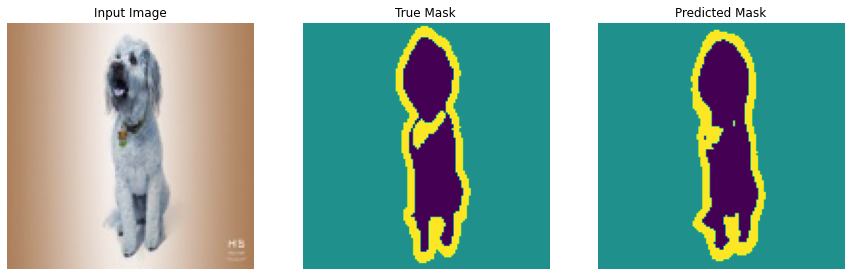

model saved


Epoch 94/100: 100%|██████████| 800/800 [01:36<00:00,  8.26img/s, loss (batch)=0.116]


(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


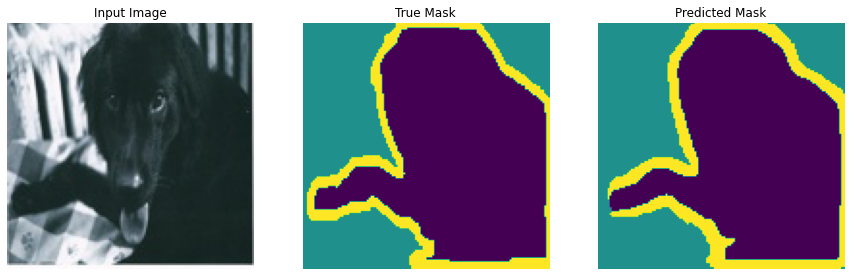

model saved


Epoch 95/100: 100%|██████████| 800/800 [01:37<00:00,  8.24img/s, loss (batch)=0.0606]


(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


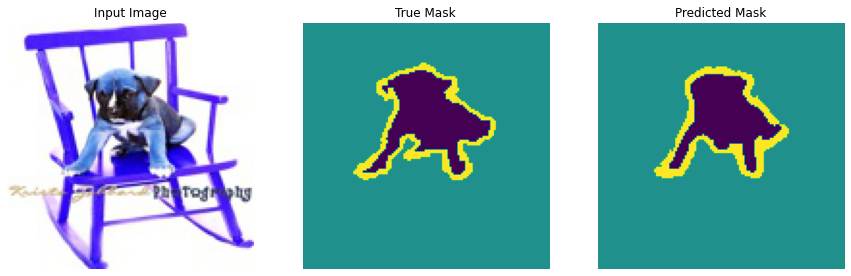

model saved


Epoch 96/100: 100%|██████████| 800/800 [01:38<00:00,  8.14img/s, loss (batch)=0.0666]


(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


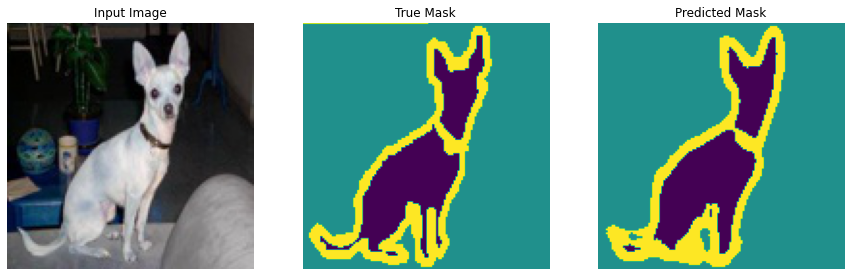

model saved


Epoch 97/100: 100%|██████████| 800/800 [01:37<00:00,  8.18img/s, loss (batch)=0.105]


(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


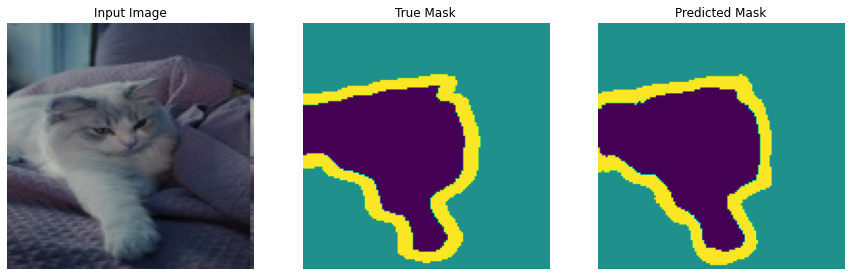

model saved


Epoch 98/100: 100%|██████████| 800/800 [01:37<00:00,  8.19img/s, loss (batch)=0.122]


(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


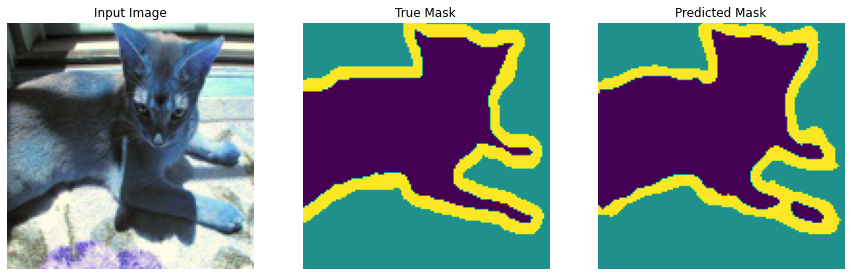

model saved


Epoch 99/100: 100%|██████████| 800/800 [01:37<00:00,  8.20img/s, loss (batch)=0.0791]


(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


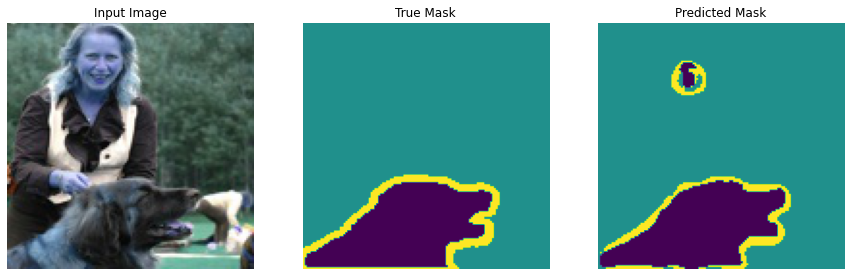

model saved


Epoch 100/100: 100%|██████████| 800/800 [01:38<00:00,  8.13img/s, loss (batch)=0.187]


(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


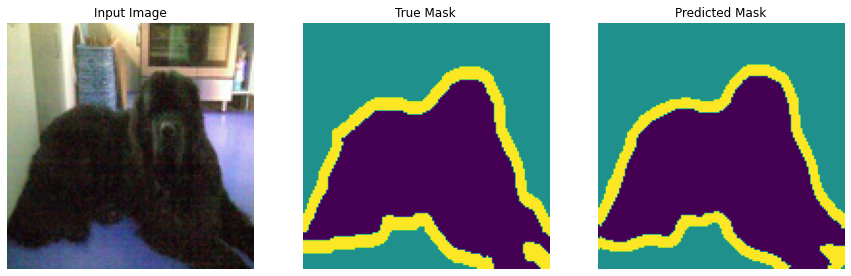

model saved


In [ ]:




device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

batch_size = 1
learning_rate = 0.01
amp = False
epochs = 100
train_per =0.8
total_images= 1000
save_checkpoint= True        

bilinear = False
n_channels = 3
n_classes = 3

print("\tDevice is",device)
model = UNet(n_channels=n_channels, n_classes=n_classes,bilinear=bilinear).to(device,non_blocking=True)

# for loading the trained 
try:
  if torch.cuda.is_available():
    model.load_state_dict(torch.load('/content/drive/MyDrive/checkpoint/check_epoch_72.pth', map_location=torch.device('cuda')))
  else:
    model.load_state_dict(torch.load('/content/drive/MyDrive/checkpoint/check_epoch_72.pth', map_location=torch.device('cpu')))
except Exception as e:
  print(e, " or No trained model found")

print("model created")

# print(model)
optimizer =optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss()

n_train = int(total_images*train_per)
n_test = total_images - n_train
print(n_test)
train_dataset_len = ceil(n_train/float(batch_size))

dataset = ImageData(dir_image,dir_masks)
print(len(dataset))
print(n_train)
train_dl , test_dl = torch.utils.data.random_split(dataset,[n_train, total_images-n_train],generator=torch.Generator().manual_seed(0))

train_dl = DataLoader(train_dl, shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_dl, shuffle=False, batch_size=batch_size, num_workers=4, pin_memory=True)

print("dataset created")

losses=[]

step=0
# training of the model
for epoch in range(73,epochs+1):
    model.train()

    epoch_loss =0
    with tqdm(total = n_train, desc=f'Epoch {epoch}/{epochs}', unit ='img') as p_bar:
        for batch in tqdm(train_dl, total=train_dataset_len, desc='train round', unit='img', leave=False):
            images = batch['image']
            masks = batch['mask']

            images = images.to(device, dtype=torch.float32)
            masks_true = masks.to(device, dtype= torch.long)

            # print(images.shape)
            with torch.cuda.amp.autocast(enabled=amp):
                masks_pred = model(images)
                # output shape (N,3,256,256)
                loss = criterion(masks_pred,masks_true)

            # print(loss)

            optimizer.zero_grad()
            grad_scaler.scale(loss).backward()
            grad_scaler.step(optimizer)
            grad_scaler.update()

        
            p_bar.update(images.shape[0])

            step+=1
            epoch_loss+=loss.detach().cpu().item()
            p_bar.set_postfix(**{'loss (batch)': loss.item()})


    losses.append(epoch_loss)
    try:
      os.mkdir(dir_losses)
    except Exception as e:
      pass

    with open(dir_losses+"/loss_epoch_{}.txt".format(epoch),'w') as f:
      f.write(str(epoch_loss))


    if save_checkpoint:
        try:
            os.mkdir(dir_checkpoint)
            os.mkdir(dir_checkpoint_images)
        except Exception as e:
            pass

        for batch in train_dl:
          image = batch['image']
          mask = batch['mask']

          image = image.to(device, dtype=torch.float32)
          true_mask = mask.to(device, dtype= torch.long)

          plt.figure(figsize=(15, 15))

          with torch.no_grad(): 
            try:
              mask_pred = model(image)
            except Exception as e:
              print(image.shape)
              print(image)

            mask_pred = mask_pred.argmax(dim=1)

          display_list=[image, true_mask, mask_pred]

          title = ['Input Image', 'True Mask', 'Predicted Mask']

          for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            m = display_list[i].detach().cpu().numpy()
            # m = m.squeeze()
            if m.ndim ==4:
              if m.shape[1]==3:
                m= m.squeeze()
                m= m.transpose((1,2,0))
              else:
                m =m.reshape(128,128)
            else:
              m= m.squeeze()
            print(m.shape)
            print(title[i])
            plt.imshow(m)
            
            plt.axis('off')
          
          # saving the image
          plt.savefig(dir_checkpoint_images+"/check_epoch_image_{}.png".format(epoch))
          plt.show()
          break

        torch.save(model.state_dict(),dir_checkpoint+"/check_epoch_{}.pth".format(epoch))
        print("model saved")



# Total Loss vs Epoch

In [ ]:
# for reading files of losses from drive
losses =[]
for file in os.listdir(dir_losses):
  with open(dir_losses+file,'r') as f:
    losses.append(float(f.readline()))

print(losses)

In [ ]:
# plotting the graph using matplotlib 
plt.plot(np.arange(1,len(losses)+1),losses,label='epoch_losses',marker='o') 
plt.legend() 
plt.grid()
plt.xlabel('epochs')
plt.ylabel('losses') 
plt.title('Loss vs Epoch')
plt.style.use('ggplot') 
plt.savefig('/content/drive/MyDrive/plot.png')
plt.show()

# For running trained model

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

batch_size = 1
learning_rate = 0.01
amp = False
epochs = 100
train_per =0.8
total_images= 1000
save_checkpoint= True        

bilinear = False
n_channels = 3
n_classes = 3

print("\tDevice is",device)
model = UNet(n_channels=n_channels, n_classes=n_classes,bilinear=bilinear).to(device,non_blocking=True)
try:
  if torch.cuda.is_available():
    model.load_state_dict(torch.load('/content/drive/MyDrive/check_epoch_100.pth', map_location=torch.device('cuda')))
  else:
    model.load_state_dict(torch.load('/content/drive/MyDrive/check_epoch_100.pth', map_location=torch.device('cpu')))
except Exception as e:
  print(e, " or No trained model found")


	Device is cuda:0


In [22]:
dataset = ImageData(dir_image,dir_masks)
print(len(dataset))
n_train=800
print(n_train)
train_dl , test_dl = torch.utils.data.random_split(dataset,[n_train, total_images-n_train],generator=torch.Generator().manual_seed(0))

train_dl = DataLoader(train_dl, shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_dl, shuffle=False, batch_size=batch_size, num_workers=4, pin_memory=True)

1000
800


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Model Validation

In [23]:
# evaluation of the model using dice_Score
model.eval()
n_test=200
val_dataset_len = ceil(n_test/float(batch_size))
val_score =0
val_list=[]



for batch in tqdm(test_dl, total=val_dataset_len, desc='Validation round', unit='batch', leave=False):
  image, mask_true = batch['image'], batch['mask']
  # move images and labels to correct device and type
  image = image.to(device=device, dtype=torch.float32)
  mask_true = mask_true.to(device=device, dtype=torch.long)
  mask_true = F.one_hot(mask_true, model.n_classes).permute(0, 3, 1, 2).float()

  with torch.no_grad():
    # predict the mask
    mask_pred = model(image)

  
    # convert to one-hot format
    mask_pred = F.one_hot(mask_pred.argmax(dim=1), model.n_classes).permute(0, 3, 1, 2).float()
    # compute the Dice score, ignoring background

    val_score += dice_coeff_multilabel(mask_pred, mask_true, reduce_batch=True)

try: 
  val_score =val_score /val_dataset_len
except Exception as e:
  val_score = val_score

Validation round:   0%|          | 0/200 [00:00<?, ?batch/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [24]:
print(val_score)

tensor(0.7247, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


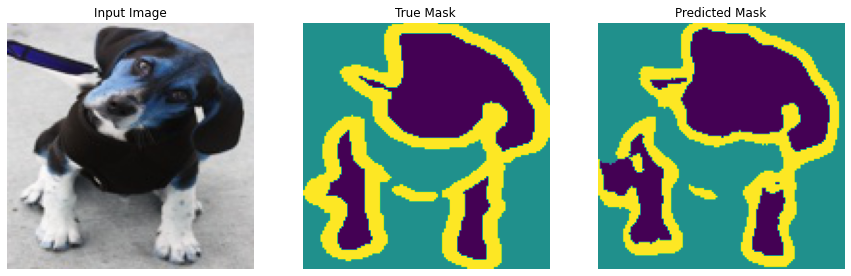

(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


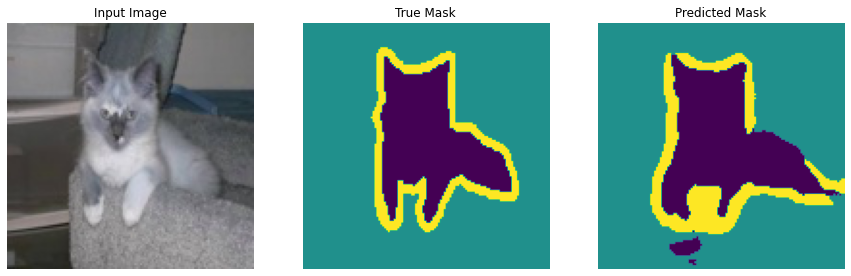

(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


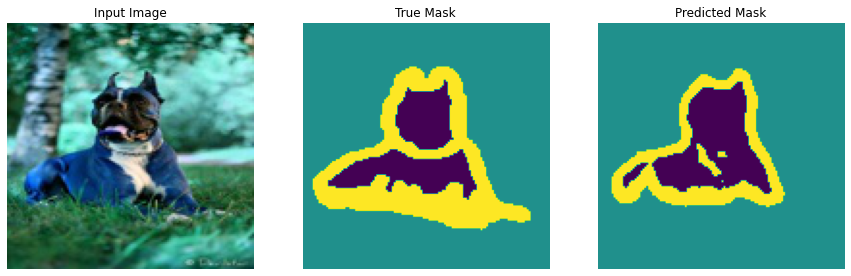

(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


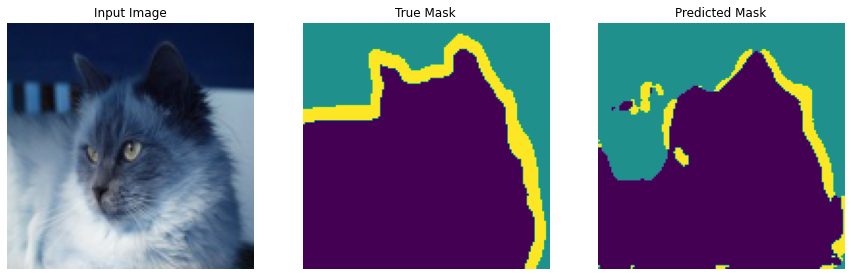

(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


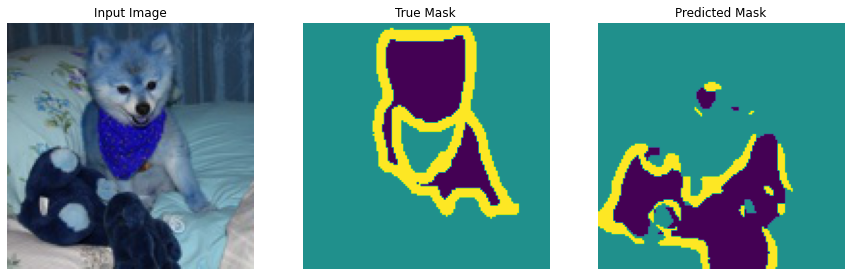

(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


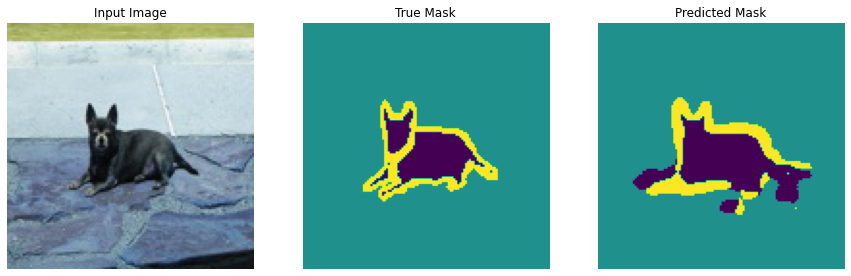

(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


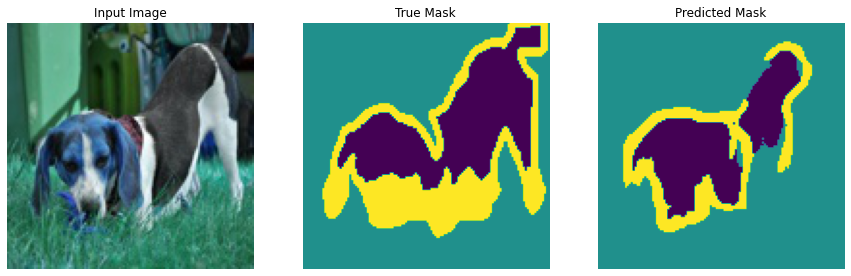

(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


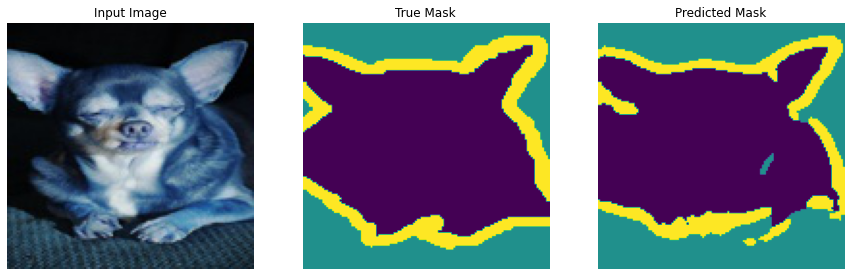

(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


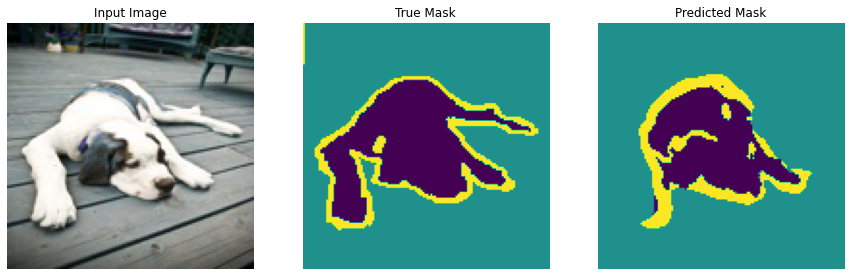

(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


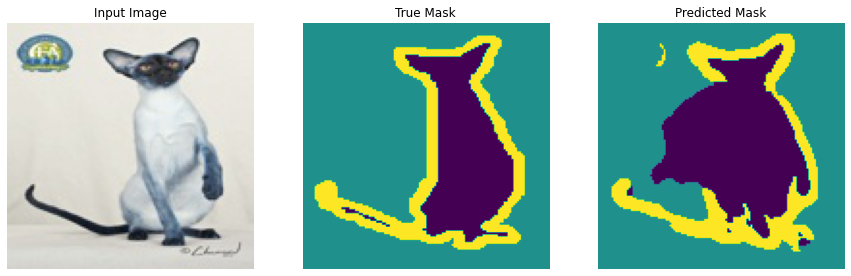

(128, 128, 3)
Input Image
(128, 128)
True Mask
(128, 128)
Predicted Mask


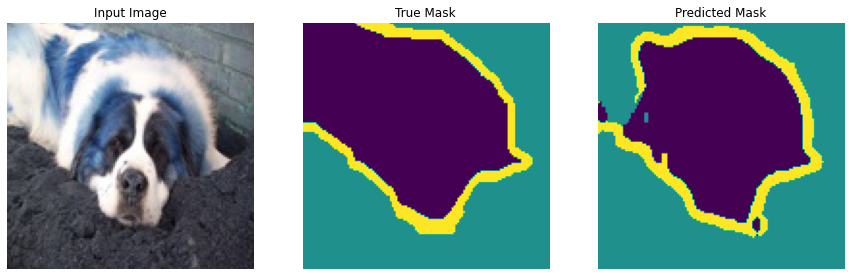

In [27]:
count=0
for batch in test_dl:
          image = batch['image']
          mask = batch['mask']

          image = image.to(device, dtype=torch.float32)
          true_mask = mask.to(device, dtype= torch.long)

          plt.figure(figsize=(15, 15))

          with torch.no_grad(): 
            try:
              mask_pred = model(image)
            except Exception as e:
              print(image.shape)
              print(image)

            mask_pred = mask_pred.argmax(dim=1)

          display_list=[image, true_mask, mask_pred]

          title = ['Input Image', 'True Mask', 'Predicted Mask']

          for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            m = display_list[i].detach().cpu().numpy()
            # m = m.squeeze()
            if m.ndim ==4:
              if m.shape[1]==3:
                m= m.squeeze()
                m= m.transpose((1,2,0))
              else:
                m =m.reshape(128,128)
            else:
              m= m.squeeze()
            print(m.shape)
            print(title[i])
            plt.imshow(m)
            
            plt.axis('off')
          
          # saving the image
          plt.show()
          count+=1
          if count>10 : 
            break

In [ ]:
count1=0
count2=0

m = os.listdir(dir_masks)
k=[]

for f in m:
  q = f.split(".")
  k.append(q[0])


for file in os.listdir(dir_image):
  q = file.split(".")[0]
  if q not in k:
    print(q)

print(count1)
print(count2)

In [ ]:
count =0
for image, mask in dataset1:
  print(image)
  m = mask.resize((128,128), resample= Image.NEAREST)
  print(np.array(m).dtype)
  # plt.figure(figsize=(15, 15))

  # display_list=[image, m]

  # title = ['Input Image', 'True Mask', 'Predicted Mask']

  # for i in range(len(display_list)):
  #   plt.subplot(1, len(display_list), i+1)
  #   plt.title(title[i])
  #   plt.imshow(display_list[i])
  #   plt.axis('off')
  # plt.show()
  break

<PIL.Image.Image image mode=RGB size=394x500 at 0x7FDF47205CD0>
uint8
